使用设备: cuda
加载数据...
训练集分布：
label
0    10000
1     1040
Name: count, dtype: int64

测试集分布：
label
0    5000
1    5000
Name: count, dtype: int64
预处理数据...
开始训练模型...
Epoch 1, Train Loss: 0.0597, Val Loss: 46.9288
Epoch 2, Train Loss: 0.0000, Val Loss: 49.2923
Epoch 3, Train Loss: 0.0000, Val Loss: 51.3388
Epoch 4, Train Loss: 0.0000, Val Loss: 53.0866
Epoch 5, Train Loss: 0.0000, Val Loss: 54.5903
Epoch 6, Train Loss: 0.0000, Val Loss: 54.7368
Early stopping triggered after 6 epochs
训练完成，耗时: 4.93 秒


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22136\3934272418.py:172: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_gru_lstm_mo

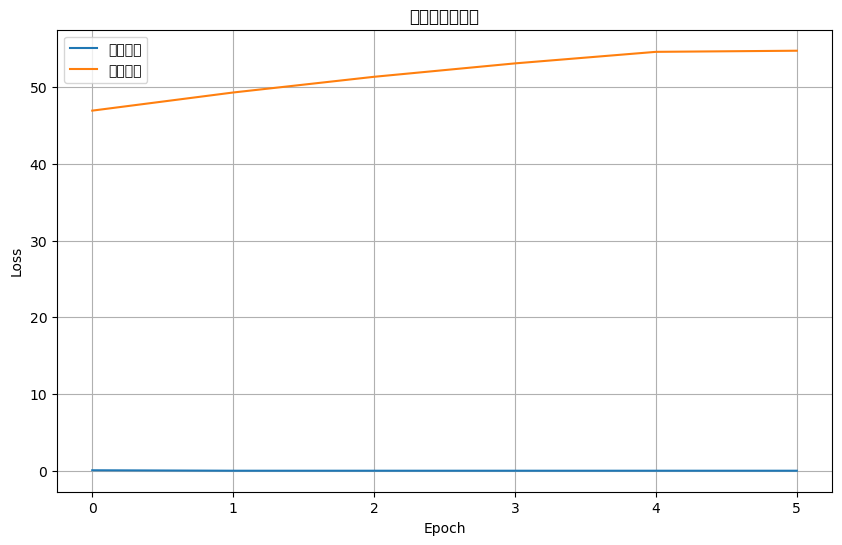

评估模型...


d:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


结果已保存到 gru_lstm_results.txt
加载数据...
训练集分布：
label
0    10000
1     1040
Name: count, dtype: int64

测试集分布：
label
0    5000
1    5000
Name: count, dtype: int64
预处理数据...
开始训练模型...
Epoch 1, Train Loss: 0.0566, Val Loss: 55.9865
Epoch 2, Train Loss: 0.0000, Val Loss: 64.8419
Epoch 3, Train Loss: 0.0000, Val Loss: 69.1330
Epoch 4, Train Loss: 0.0000, Val Loss: 72.0089
Epoch 5, Train Loss: 0.0000, Val Loss: 74.2417
Epoch 6, Train Loss: 0.0000, Val Loss: 74.4408
Early stopping triggered after 6 epochs
训练完成，耗时: 4.88 秒


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22136\3934272418.py:172: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_gru_lstm_mo

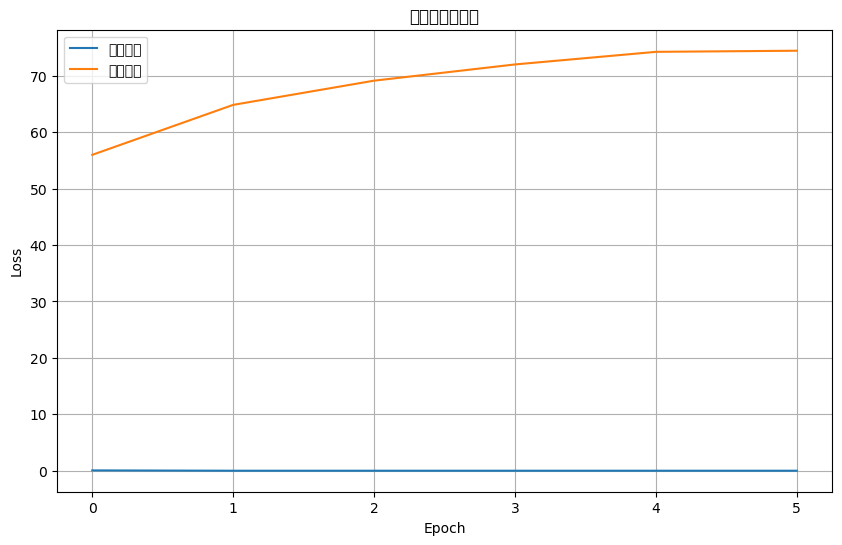

评估模型...


d:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


结果已保存到 gru_lstm_results.txt
加载数据...
训练集分布：
label
0    10000
1     1040
Name: count, dtype: int64

测试集分布：
label
0    5000
1    5000
Name: count, dtype: int64
预处理数据...
开始训练模型...
Epoch 1, Train Loss: 0.0545, Val Loss: 47.8466
Epoch 2, Train Loss: 0.0000, Val Loss: 51.7684
Epoch 3, Train Loss: 0.0000, Val Loss: 55.2706
Epoch 4, Train Loss: 0.0000, Val Loss: 58.1027
Epoch 5, Train Loss: 0.0000, Val Loss: 60.4059
Epoch 6, Train Loss: 0.0000, Val Loss: 60.6189
Early stopping triggered after 6 epochs
训练完成，耗时: 4.77 秒


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22136\3934272418.py:172: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_gru_lstm_mo

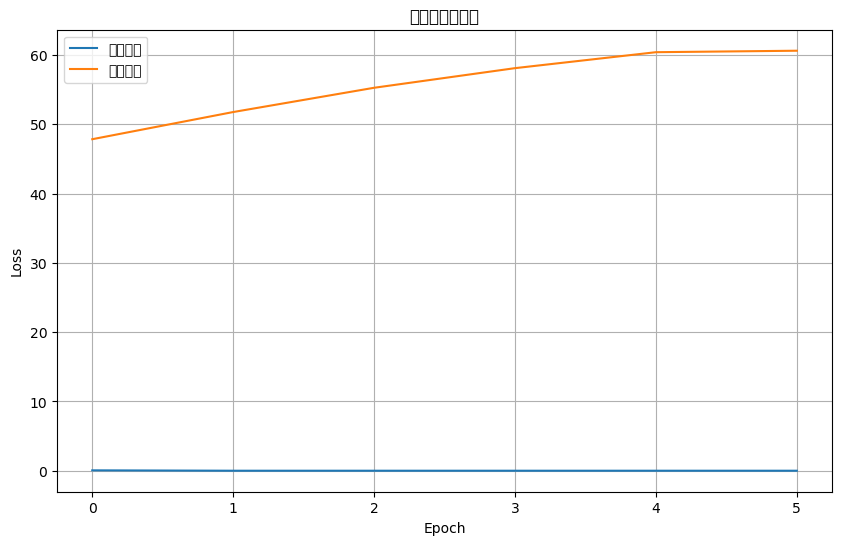

评估模型...


d:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


结果已保存到 gru_lstm_results.txt
加载数据...
训练集分布：
label
0    10000
1     1040
Name: count, dtype: int64

测试集分布：
label
0    5000
1    5000
Name: count, dtype: int64
预处理数据...
开始训练模型...
Epoch 1, Train Loss: 0.0527, Val Loss: 50.2262
Epoch 2, Train Loss: 0.0000, Val Loss: 58.4298
Epoch 3, Train Loss: 0.0000, Val Loss: 62.9485
Epoch 4, Train Loss: 0.0000, Val Loss: 65.9692
Epoch 5, Train Loss: 0.0000, Val Loss: 68.2537
Epoch 6, Train Loss: 0.0000, Val Loss: 68.4593
Early stopping triggered after 6 epochs
训练完成，耗时: 4.88 秒


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22136\3934272418.py:172: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_gru_lstm_mo

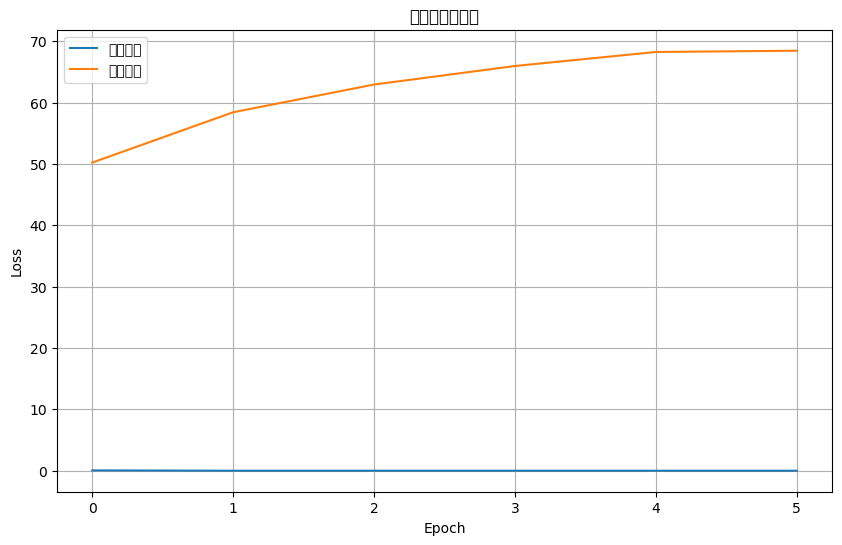

评估模型...


d:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


结果已保存到 gru_lstm_results.txt
加载数据...
训练集分布：
label
0    10000
1     1040
Name: count, dtype: int64

测试集分布：
label
0    5000
1    5000
Name: count, dtype: int64
预处理数据...
开始训练模型...
Epoch 1, Train Loss: 0.0655, Val Loss: 52.4027
Epoch 2, Train Loss: 0.0000, Val Loss: 61.2814
Epoch 3, Train Loss: 0.0000, Val Loss: 65.7682
Epoch 4, Train Loss: 0.0000, Val Loss: 68.7796
Epoch 5, Train Loss: 0.0000, Val Loss: 70.9759
Epoch 6, Train Loss: 0.0000, Val Loss: 71.1821
Early stopping triggered after 6 epochs
训练完成，耗时: 4.54 秒


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22136\3934272418.py:172: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_gru_lstm_mo

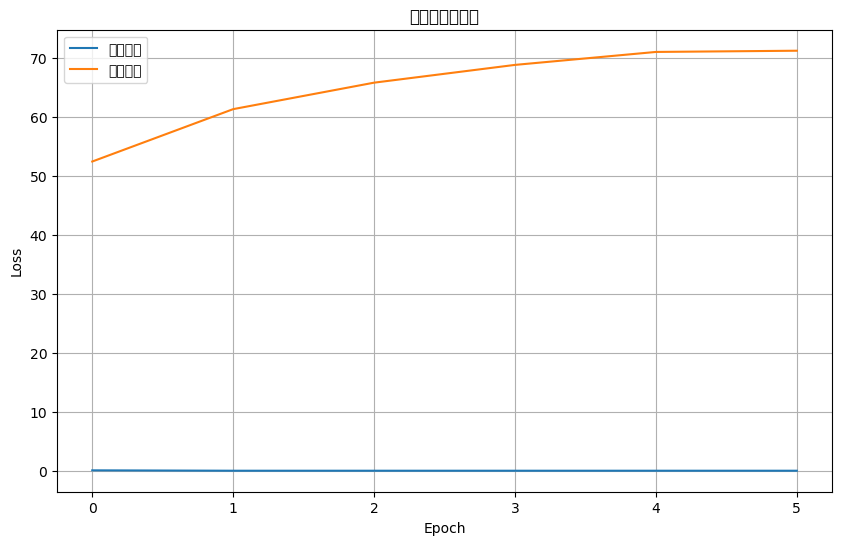

评估模型...


d:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


结果已保存到 gru_lstm_results.txt
加载数据...
训练集分布：
label
0    10000
1     1040
Name: count, dtype: int64

测试集分布：
label
0    5000
1    5000
Name: count, dtype: int64
预处理数据...
开始训练模型...


KeyboardInterrupt: 

In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

# 设置随机种子以确保结果可复现
torch.manual_seed(42)
np.random.seed(42)

# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 自定义数据集类
class IntrusionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# 定义GRU+LSTM混合模型
class GRU_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size_gru=128, hidden_size_lstm=64, dropout=0.3):
        super(GRU_LSTM, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size_gru, batch_first=True, bidirectional=True)  # 使用双向GRU
        self.dropout1 = nn.Dropout(dropout)
        self.lstm = nn.LSTM(hidden_size_gru*2, hidden_size_lstm, batch_first=True, bidirectional=True)  # 使用双向LSTM
        self.dropout2 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size_lstm*2, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        gru_out, _ = self.gru(x)
        gru_out = self.dropout1(gru_out)
        
        lstm_out, _ = self.lstm(gru_out)
        lstm_out = self.dropout2(lstm_out[:, -1, :])
        
        out = self.relu(self.fc1(lstm_out))
        out = self.fc2(out)  # 不使用sigmoid，交给BCEWithLogitsLoss处理
        return out

# 数据加载函数
def load_data(train_self_path, train_nonself_path, test_self_path, test_nonself_path):
    # 加载训练数据
    train_self = pd.read_csv(train_self_path)
    train_self = train_self.sample(n=10000,random_state=42)
    train_nonself = pd.read_csv(train_nonself_path)
    
    # 加载测试数据
    test_self = pd.read_csv(test_self_path)
    test_self = test_self.sample(n=5000,random_state=42)
    test_nonself = pd.read_csv(test_nonself_path)
    test_nonself = test_nonself.sample(n=5000,random_state=42)
    
    # 添加标签：自体为0，非自体为1
    train_self['label'] = 0
    train_nonself['label'] = 1
    test_self['label'] = 0
    test_nonself['label'] = 1
    
    # 合并训练集和测试集
    train_data = pd.concat([train_self, train_nonself], axis=0).reset_index(drop=True)
    test_data = pd.concat([test_self, test_nonself], axis=0).reset_index(drop=True)
    print("训练集分布：")
    print(train_data['label'].value_counts())
    print("\n测试集分布：")
    print(test_data['label'].value_counts())
    return train_data, test_data

# 数据预处理函数
def preprocess_data(train_data, test_data):
    # 分离特征和标签
    X_train = train_data.drop('label', axis=1).values
    y_train = train_data['label'].values
    X_test = test_data.drop('label', axis=1).values
    y_test = test_data['label'].values
    
    # 创建时间序列数据
    sequence_length = 5
    X_train_seq = create_sequences(X_train, sequence_length)
    X_test_seq = create_sequences(X_test, sequence_length)
    
    # 确保标签对应
    y_train = train_data['label'].values[sequence_length-1:]
    y_test = test_data['label'].values[sequence_length-1:]
    
    return X_train_seq, y_train, X_test_seq, y_test

def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i+sequence_length])
    return np.array(sequences)

# 训练模型函数
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    model.to(device)
    
    # 用于早停的变量
    best_val_loss = float('inf')
    early_stop_counter = 0
    
    # 记录训练和验证损失
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        # 训练阶段
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            
            outputs = model(features)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels.unsqueeze(1).float())
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # 更新学习率
        scheduler.step(val_loss)
        
        # 早停检查
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), 'best_gru_lstm_model.pth')
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
    
    # 加载最佳模型
    model.load_state_dict(torch.load('best_gru_lstm_model.pth'))
    
    return model, train_losses, val_losses

# 评估模型性能
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            
            outputs = model(features)
            predicted = (outputs >= 0).float()  # 使用0作为阈值，因为使用了BCEWithLogitsLoss
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels)
    
    # 计算评估指标
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return accuracy, precision, recall, f1, conf_matrix

# 主函数
def main():
    unknown_types = ["A", "B", "D", "E", "F", "G", "R", "S", "W"]
    for unknown_type in unknown_types:
        # 设置数据路径
        train_self_path = '../../check/self/train_self_new.csv'
        train_nonself_path = f'../../check/train/trainset_{unknown_type}_nonself.csv'
        test_self_path = '../../check/self/test_self_new.csv'
        test_nonself_path = '../../check/nonself/test_nonself.csv'
        
        # 加载数据
        print("加载数据...")
        train_data, test_data = load_data(train_self_path, train_nonself_path, test_self_path, test_nonself_path)
        
        # 预处理数据
        print("预处理数据...")
        X_train, y_train, X_test, y_test = preprocess_data(train_data, test_data)
        
        # 创建数据集和数据加载器
        # 将训练集分为训练集和验证集（80%训练，20%验证）
        train_size = int(0.8 * len(X_train))
        val_size = len(X_train) - train_size
        
        X_train_split, X_val = X_train[:train_size], X_train[train_size:]
        y_train_split, y_val = y_train[:train_size], y_train[train_size:]
        
        train_dataset = IntrusionDataset(X_train_split, y_train_split)
        val_dataset = IntrusionDataset(X_val, y_val)
        test_dataset = IntrusionDataset(X_test, y_test)
        
        batch_size = 64
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)
        
         # 创建模型
        input_size = X_train.shape[2]  # 特征维度
        model = GRU_LSTM(input_size)
        
        # 计算正样本权重
        pos_weight = torch.tensor([(y_train == 0).sum() / (y_train == 1).sum()])
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
        
        # 使用带权重衰减的优化器
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
        
        # 添加学习率调度器
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)
        
        # 训练模型
        print("开始训练模型...")
        start_time = time.time()
        model, train_losses, val_losses = train_model(
            model, 
            train_loader, 
            val_loader, 
            criterion, 
            optimizer,
            scheduler,  # 添加scheduler参数
            num_epochs=30, 
            patience=5
        )
        training_time = time.time() - start_time
        print(f"训练完成，耗时: {training_time:.2f} 秒")
        
        # 绘制损失曲线
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='训练损失')
        plt.plot(val_losses, label='验证损失')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('训练和验证损失')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # 评估模型
        print("评估模型...")
        accuracy, precision, recall, f1, conf_matrix = evaluate_model(model, test_loader)
        
        # 保存结果
        results = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'training_time': training_time,
            'confusion_matrix': conf_matrix.tolist()
        }
        
        # 将结果保存为文本文件
        with open('gru_lstm_results.txt', 'w') as f:
            for key, value in results.items():
                if key != 'confusion_matrix':
                    f.write(f"{key}: {value}\n")
            f.write(f"confusion_matrix:\n{conf_matrix}\n")
        
        print("结果已保存到 gru_lstm_results.txt")

if __name__ == "__main__":
    main()